## **Importing Libraries and input data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [93]:
!pip install geopandas

     |████████████████████████████████| 1.0MB 5.3MB/s 
     |████████████████████████████████| 6.5MB 15.2MB/s 
     |████████████████████████████████| 15.3MB 54.8MB/s 


**Reading input data**

In [ ]:
!pip install category_encoders

In [94]:
import pandas as pd
import numpy as np
# import geopandas as gpd
from shapely.geometry import Point,Polygon,LineString
import matplotlib.pyplot as plt
from category_encoders import *

ModuleNotFoundError: ignored

# Reading & Analysing Data

1.   Reading data
2.   Checking for outliers 
3.   saving the modified file to a csv to import back with pyspark for merging operations

Unable to handle huge data in colab hence need to use pyspark for handling huge data , therefore using pyspark to merge and subset Itemwise data for modelling time series



Function to Reduce Dataframe memory

In [ ]:
#***** Function to reduce dataframe memory**************************************#

def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

#*******************************************************************************************************

In [3]:
train=pd.read_csv('/content/drive/MyDrive/Final_Hack/train.csv',low_memory=False)


In [ ]:
test=pd.read_csv('/content/drive/MyDrive/Final_Hack/test.csv')

KeyboardInterrupt: ignored

Identifying Items not in train dataset and is in test dataset


---


# Reading additional data


In [4]:
location=pd.read_csv('/content/drive/MyDrive/Final_Hack/location_details.csv')
item_id=pd.read_csv('/content/drive/MyDrive/Final_Hack/item_details.csv')
transaction_train=pd.read_csv('/content/drive/MyDrive/Final_Hack/train_transactions.csv')

In [ ]:
transaction_train['date']=transaction_train['date'].astype('category')
transaction_train['location_identifier']=transaction_train['location_identifier'].astype('category')

In [5]:
df=pd.merge(train,location,how='left',left_on='locationId',right_on='location_id')
df.shape

(101688779, 10)

In [6]:
df2=pd.merge(df,item_id,how='left',left_on='item_id',right_on='item_id')
df2.shape

(101688779, 13)

In [ ]:
# df3=pd.merge(df2,transaction_train,how='left',left_on='location_id',right_on='location_identifier')
# df3.shape
df=pd.merge(train,transaction_train,how='left',left_on='locationId',right_on='location_identifier')
df.shape

In [ ]:
train.dtypes

date            object
locationId      object
item_id         object
unit_sales     float64
onpromotion     object
dtype: object

In [7]:
df2['date']=pd.to_datetime(df2['date'])
df2['location_id']=df2['location_id'].astype('category')
df2['item_id']=df2['item_id'].astype('category')
df2['onpromotion']=df2['onpromotion'].astype('category')
df2['city']=df2['city'].astype('category')
df2['state']=df2['state'].astype('category')
df2['locationId']=df2['locationId'].astype('category')
df2['type']=df2['type'].astype('category')
df2['cluster']=df2['cluster'].astype('category')
df2['category_of_item']=df2['category_of_item'].astype('category')
df2['class']=df2['class'].astype('category')
df2['perishable']=df2['perishable'].astype('category')

# train['date']=pd.to_datetime(train['date'])
# train['locationId']=train['locationId'].astype('category')
# train['item_id']=train['item_id'].astype('category')
# train['onpromotion']=train['onpromotion'].astype('category')

In [8]:
Q1=(df2['unit_sales'].sort_values(ascending=True)).quantile(0.25)
Q3=(df2['unit_sales'].sort_values(ascending=True)).quantile(0.75)
IQR=(Q3-Q1)


In [9]:
train_1=df2.loc[df2['unit_sales']>(Q1-1.5*IQR)]
df2=train_1.loc[train_1['unit_sales']<(Q3+1.5*IQR)]
df2.shape

(92165832, 13)

In [ ]:
df2['unit_sales'].describe()

count    9.216583e+07
mean     5.063393e+00
std      4.328432e+00
min     -8.329000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      7.000000e+00
max      1.949900e+01
Name: unit_sales, dtype: float64

In [ ]:
train, NAlist = reduce_mem_usage(df2)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

NameError: ignored

In [10]:
df2.drop('location_id',axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df2.head(1)

,date,locationId,item_id,unit_sales,onpromotion,city,state,type,cluster,category_of_item,class,perishable
0,2015-01-01,location_25,item_103665,7.0,NaN,Kanpur,Uttar Pradesh,D,1,baked_items / bread_based,class_2712,1


Only to save for spark usage to csv can be use

---



---



In [11]:
df2['year']=df2['date'].dt.year
df2['month']=df2['date'].dt.month
df2['day']=df2['date'].dt.day
df2['dayofweek']=df2['date'].dt.dayofweek

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
df2.drop(df2[df2['month']==12].index | df2[df2['month']==10].index | df2[df2['month']==9].index | df2[df2['month']==11].index,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df2['class'].unique()

['class_2712', 'class_1045', 'class_1030', 'class_2644', 'class_3044', ..., 'class_2168', 'class_1150', 'class_3116', 'class_6233', 'class_1079']
Length: 319
Categories (319, object): ['class_2712', 'class_1045', 'class_1030', 'class_2644', ..., 'class_1150',
                           'class_3116', 'class_6233', 'class_1079']

In [ ]:
class_1=df2[['locationId','category_of_item','month','item_id','unit_sales']]
class_2=df2[['onpromotion','city','state','unit_sales']]
class_3=df2[['type','class','dayofweek','unit_sales']]

In [ ]:
df2.drop('date', axis=1, inplace=True)
#df2.drop('item_id', axis=1, inplace=True)
df2.drop('class', axis=1, inplace=True)
df2.drop('cluster', axis=1, inplace=True)
df2.drop('onpromotion', axis=1, inplace=True)
df2.drop('type', axis=1, inplace=True)
df2.drop('city', axis=1, inplace=True)
df2.drop('state', axis=1, inplace=True)
df2.drop('day', axis=1, inplace=True)
df2.drop('year', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df2.drop('day', axis=1, inplace=True)

KeyError: ignored

In [ ]:
df2.drop('perishable',axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df2.head()

,locationId,item_id,unit_sales,category_of_item,perishable,month
0,location_25,item_103665,7.0,baked_items / bread_based,1,1
1,location_25,item_105574,1.0,grocery_items,0,1
2,location_25,item_105575,2.0,grocery_items,0,1
3,location_25,item_108079,1.0,grocery_items,0,1
4,location_25,item_108701,1.0,deli_items,1,1


In [ ]:
class_1['month']=class_1['month'].astype('category')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
class_1.dtypes

locationId          category
category_of_item    category
month               category
item_id             category
unit_sales           float64
dtype: object

In [ ]:
class_2['onpromotion'].fillna(class_2['onpromotion'].mode()[0],inplace=True)
#class_2['onpromotion'].mode()[0]
class_2['onpromotion']=class_2['onpromotion'].astype('int')

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
class_3.dtypes

type          category
class         category
dayofweek        int64
unit_sales     float64
dtype: object

In [ ]:
class_3['dayofweek']=class_3['dayofweek'].astype('category')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
X=class_3.drop('unit_sales',axis=1)
y=class_3[['unit_sales']]
enc=TargetEncoder(cols=['type','class','dayofweek'])
training_numeric_dataset2=enc.fit_transform(X,y)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
from pickle import dump
dump(enc,open('/content/drive/MyDrive/Final_Hack/c3.pkl','wb'))

In [ ]:
training_numeric_dataset2['unit_sales']=df2['unit_sales']

In [ ]:
training_numeric_dataset['item_id']=training_numeric_dataset['item_id'].astype('float32')
training_numeric_dataset['locationId']=training_numeric_dataset['locationId'].astype('float32')
training_numeric_dataset['category_of_item']=training_numeric_dataset['category_of_item'].astype('float32')
#training_numeric_dataset['perishable']=training_numeric_dataset['perishable'].astype('float32')
training_numeric_dataset['month']=training_numeric_dataset['month'].astype('float32')
training_numeric_dataset['unit_sales']=training_numeric_dataset['unit_sales'].astype('float32')

In [ ]:
training_numeric_dataset1['city']=training_numeric_dataset1['city'].astype('float32')
training_numeric_dataset1['state']=training_numeric_dataset1['state'].astype('float32')

In [ ]:
training_numeric_dataset2['type']=training_numeric_dataset2['type'].astype('float32')
training_numeric_dataset2['class']=training_numeric_dataset2['class'].astype('float32')
training_numeric_dataset2['dayofweek']=training_numeric_dataset2['dayofweek'].astype('float32')

In [ ]:
# df3=df2.sample(n=30000000)
training_numeric_dataset2.to_pickle('/content/drive/MyDrive/Final_Hack/C3_data')

In [ ]:
training_numeric_dataset2.head()

,type,class,dayofweek,unit_sales
0,4.857485,4.663194,4.95274,7.0
1,4.857485,6.517628,4.95274,1.0
2,4.857485,6.517628,4.95274,2.0
3,4.857485,3.007533,4.95274,1.0
4,4.857485,4.807457,4.95274,1.0


In [ ]:
df2.to_pickle('/content/drive/MyDrive/Final_Hack/train_WithoutLastmonths')

In [ ]:
df2['year']=df2['year'].astype(np.int32)
df2['month']=df2['month'].astype(np.int8)
df2['day']=df2['day'].astype(np.int8)
#df2['dayofweek']=df2['dayofweek'].astype(np.int32)
df2.dtypes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

date                datetime64[ns]
locationId                category
item_id                   category
unit_sales                 float64
onpromotion               category
city                      category
state                     category
type                      category
cluster                   category
category_of_item          category
class                     category
perishable                category
year                         int32
month                         int8
day                           int8
dtype: object

In [ ]:
df2.drop('dayofweek',axis=1,inplace=True)

,date,locationId,item_id,unit_sales,onpromotion,city,state,type,cluster,category_of_item,class,perishable,year,month,day
0,2015-01-01,location_25,item_103665,7.0,NaN,Kanpur,Uttar Pradesh,D,1,baked_items / bread_based,class_2712,1,2015,1,1
1,2015-01-01,location_25,item_105574,1.0,NaN,Kanpur,Uttar Pradesh,D,1,grocery_items,class_1045,0,2015,1,1
2,2015-01-01,location_25,item_105575,2.0,NaN,Kanpur,Uttar Pradesh,D,1,grocery_items,class_1045,0,2015,1,1
3,2015-01-01,location_25,item_108079,1.0,NaN,Kanpur,Uttar Pradesh,D,1,grocery_items,class_1030,0,2015,1,1
4,2015-01-01,location_25,item_108701,1.0,NaN,Kanpur,Uttar Pradesh,D,1,deli_items,class_2644,1,2015,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101688774,2018-12-31,location_54,item_2048381,6.0,True,Patna,Bihar,C,3,grocery_items,class_1016,0,2018,12,31
101688775,2018-12-31,location_54,item_2048421,4.0,False,Patna,Bihar,C,3,grocery_items,class_1016,0,2018,12,31
101688776,2018-12-31,location_54,item_2048471,10.0,False,Patna,Bihar,C,3,grocery_items,class_1016,0,2018,12,31
101688777,2018-12-31,location_54,item_2048515,3.0,False,Patna,Bihar,C,3,grocery_items,class_1016,0,2018,12,31


In [ ]:
df2['unit_sales']=df2['unit_sales'].apply(abs)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Merge operation Using BigData(Pyspark)

1.   Merging tables
2.   Extracting and saving one item data to a pickle file
3.   Finding highest Item sold
4.   Subsetting the Itemwise data and converting to pandas dataframe
5.   Saving to pickle file for faster access during modelling



In [ ]:
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q https://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
# !tar xf /content/spark-2.4.7-bin-hadoop2.7.tgz
# !pip install -q findspark

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz

!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"

In [ ]:
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .appName("Spark ML_Regression Application")\
        .master('local[*]')\
        .getOrCreate()

In [ ]:
# from pyspark.sql import SparkSession
# spark = SparkSession.builder\
#         .appName("Spark ML Application")\
#         .master('local[*]')\
#         .getOrCreate()

In [ ]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [ ]:
TrainDataSchema = StructType([
    StructField("date", TimestampType(), True),
    StructField("locationId", StringType(), True),
    StructField("item_id", StringType(), True),
    StructField("unit_sales", DoubleType(), True),
    StructField("onpromotion", BooleanType(), True),
    StructField("city", string(), True),
    StructField("state", BooleanType(), True),
    StructField("type", BooleanType(), True),
    StructField("cluster", BooleanType(), True),
    StructField("category_of_item", BooleanType(), True),
    StructField("class", BooleanType(), True),
    StructField("perishable", BooleanType(), True),
    StructField("year", BooleanType(), True),
    StructField("month", BooleanType(), True),
    StructField("day", BooleanType(), True),
    StructField("dayofweek", string(), True)])

root
 |-- _c0: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- locationId: string (nullable = true)
 |-- item_id: string (nullable = true)
 |-- unit_sales: double (nullable = true)
 |-- onpromotion: boolean (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- type: string (nullable = true)
 |-- cluster: integer (nullable = true)
 |-- category_of_item: string (nullable = true)
 |-- class: string (nullable = true)
 |-- perishable: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)

In [ ]:
train_sparkdf = spark.read.csv(path='/content/drive/MyDrive/Final_Hack/train_without_Outlier.csv',header=True,inferSchema=True)


#106565000


In [ ]:
location=spark.read.csv(path='/content/drive/MyDrive/Final_Hack/location_details.csv',header=True,inferSchema=True)
item_id=spark.read.csv(path='/content/drive/MyDrive/Final_Hack/item_details.csv',header=True,inferSchema=True)
transactions=spark.read.csv(path='/content/drive/MyDrive/Final_Hack/train_transactions.csv',header=True,inferSchema=True)

In [ ]:
train_sparkdf.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- locationId: string (nullable = true)
 |-- item_id: string (nullable = true)
 |-- unit_sales: double (nullable = true)
 |-- onpromotion: boolean (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- type: string (nullable = true)
 |-- cluster: integer (nullable = true)
 |-- category_of_item: string (nullable = true)
 |-- class: string (nullable = true)
 |-- perishable: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)



In [ ]:
#train.select(min("unit_sales"), max("unit_sales")).show()
train_sparkdf.count()

91913445

In [ ]:
train_sparkdf.filter(train_sparkdf.unit_sales<0).show()

+---+----+----------+-------+----------+-----------+----+-----+----+-------+----------------+-----+----------+----+-----+---+---------+
|_c0|date|locationId|item_id|unit_sales|onpromotion|city|state|type|cluster|category_of_item|class|perishable|year|month|day|dayofweek|
+---+----+----------+-------+----------+-----------+----+-----+----+-------+----------------+-----+----------+----+-----+---+---------+
+---+----+----------+-------+----------+-----------+----+-----+----+-------+----------------+-----+----------+----+-----+---+---------+



In [ ]:
train_df=train_sparkdf

In [ ]:
df1=train_df.drop('_c0','onpromotion','city','state','cluster','class','year')

In [ ]:
df1.show()

+-------------------+-----------+-----------+----------+----+--------------------+----------+-----+---+---------+
|               date| locationId|    item_id|unit_sales|type|    category_of_item|perishable|month|day|dayofweek|
+-------------------+-----------+-----------+----------+----+--------------------+----------+-----+---+---------+
|2015-01-01 00:00:00|location_25|item_103665|       7.0|   D|baked_items / bre...|         1|    1|  1|        3|
|2015-01-01 00:00:00|location_25|item_105574|       1.0|   D|       grocery_items|         0|    1|  1|        3|
|2015-01-01 00:00:00|location_25|item_105575|       2.0|   D|       grocery_items|         0|    1|  1|        3|
|2015-01-01 00:00:00|location_25|item_108079|       1.0|   D|       grocery_items|         0|    1|  1|        3|
|2015-01-01 00:00:00|location_25|item_108701|       1.0|   D|          deli_items|         1|    1|  1|        3|
|2015-01-01 00:00:00|location_25|item_108786|       3.0|   D|  cleaning_utilities|      

In [ ]:
train_sparkdf.where(train_sparkdf.onpromotion.isNull()).count()

19475641

In [ ]:
(trainingData, testData) = df1.randomSplit([0.7, 0.3], seed= 123)

In [ ]:
num_Var_Names = [c[0] for c in trainingData.dtypes if c[1] in ['double']]
cat_Var_Names = [c[0] for c in trainingData.dtypes if c[1] in ['string','int']]
print(num_Var_Names)
print(cat_Var_Names)

['unit_sales']
['locationId', 'item_id', 'type', 'category_of_item', 'perishable', 'month', 'day', 'dayofweek']


In [ ]:
num_Var_Names.remove('unit_sales')

In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

indexers_Cat = [StringIndexer(inputCol=cat_Var_Name, outputCol="{0}_index".format(cat_Var_Name)) for cat_Var_Name in cat_Var_Names ]
encoders_Cat = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="{0}_vec".format(indexer.getInputCol())) for indexer in indexers_Cat]
assembler_Cat = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders_Cat], outputCol="cat_features")

assembler = VectorAssembler(inputCols=["cat_features"], outputCol="features")

In [ ]:
preprocessiong_Stages = indexers_Cat+encoders_Cat+[assembler_Cat]+[assembler]

In [ ]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=100,labelCol="unit_sales", featuresCol="features")

In [ ]:
from pyspark.ml import Pipeline

lr_Pipeline = Pipeline(stages=preprocessiong_Stages+[lr])

lr_Pipeline_model = lr_Pipeline.fit(trainingData)

Streaming output truncated to the last 5000 lines.
Traceback (most recent call last):
  File "/content/spark-2.3.1-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1159, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/content/spark-2.3.1-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 985, in send_command
    response = connection.send_command(command)
  File "/content/spark-2.3.1-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1164, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:45125)
Traceback (most recent call last):
  File "/usr/local

Py4JNetworkError: ignored

In [ ]:
import pyspark.sql.functions as func
train.filter(func.col('unit_sales')<=0).count()

6162

In [ ]:
train.select('unit_sales').summary().show()

+-------+------------------+
|summary|        unit_sales|
+-------+------------------+
|  count|         101688779|
|   mean| 8.647889531772222|
| stddev|23.495334049010957|
|    min|          -15372.0|
|    25%|               2.0|
|    50%|               4.0|
|    75%|               9.0|
|    max|           89440.0|
+-------+------------------+



In [ ]:

train=train.withColumn('unit_sales',func.abs('unit_sales'))
train.filter(func.col('unit_sales')<=0)



SyntaxError: ignored

In [ ]:
location=location.withColumnRenamed('location_id','locationId')
#location.show(5)

In [ ]:
df1=train_sparkdf.join(other=location,on='locationId',how='left')

In [ ]:
#df1.show(5)

In [ ]:
#item_id.show(5)

In [ ]:
df2=df1.join(other=item_id,on='item_id',how='left')
#df2.show(5)

In [ ]:
print(train.count())
print(df2.count())

In [ ]:
print(df1.count())

In [ ]:
#transactions.show(5)

In [ ]:
transactions=transactions.withColumnRenamed('location_identifier','locationId')
#transactions.show(5)

In [ ]:
df3=df2.join(transactions,on=['date','locationId'],how='left')

In [ ]:
df3.show(5)

+----------+-----------+-----------+---+----------+-----------+------+-------------+----+-------+--------------------+----------+----------+------------+
|      date| locationId|    item_id|_c0|unit_sales|onpromotion|  city|        state|type|cluster|    category_of_item|     class|perishable|transactions|
+----------+-----------+-----------+---+----------+-----------+------+-------------+----+-------+--------------------+----------+----------+------------+
|2015-01-01|location_25|item_103665|  0|       7.0|       null|Kanpur|Uttar Pradesh|   D|      1|baked_items / bre...|class_2712|         1|         770|
|2015-01-01|location_25|item_105574|  1|       1.0|       null|Kanpur|Uttar Pradesh|   D|      1|       grocery_items|class_1045|         0|         770|
|2015-01-01|location_25|item_105575|  2|       2.0|       null|Kanpur|Uttar Pradesh|   D|      1|       grocery_items|class_1045|         0|         770|
|2015-01-01|location_25|item_108079|  3|       1.0|       null|Kanpur|Uttar 

**Finding the Item that sold maximum units**



---



---





In [ ]:
item_sales=df3.groupby('item_id').sum('unit_sales').toDF('item_id','total_sales')

In [ ]:
#item_sales.describe("total_sales").filter("summary = 'max'").show()
item_sales.describe("total_sales").filter("summary = 'min'")

KeyboardInterrupt: ignored

In [ ]:
sales_Item=item_sales.toPandas()

In [ ]:
sales_Item.to_pickle('/content/drive/MyDrive/Final_Hack/Highest_Item_sales')

In [ ]:
sales_Item[sales_Item['total_sales']==sales_Item.total_sales.min()]

,item_id,total_sales
767,item_1047793,3.0


**Finding Highest item sold in perishable category and non perishable category**

In [ ]:
Perishable_Items=df3.groupby('perishable','item_id').sum('unit_sales').toDF('perishable','item_id','total_sales')

In [ ]:
Perishable_Items.show()

+----------+------------+------------------+
|perishable|     item_id|       total_sales|
+----------+------------+------------------+
|         0| item_261700|          601582.0|
|         0|item_1060036|          281685.0|
|         0|item_1102268|          283301.0|
|         0| item_724498|          677475.0|
|         0|item_1012788|          168023.0|
|         1|item_1038950|          118772.0|
|         0| item_929627|          178274.0|
|         1| item_358134|          160812.0|
|         1|item_1696007| 842414.5574000002|
|         0|item_1248391|          119387.0|
|         1|item_1550461|196394.33479999998|
|         0|item_1359503|           95337.0|
|         0|item_1449645|            4003.0|
|         0|item_1913055|            4504.0|
|         0|item_1917879|           68294.0|
|         1|item_2007250|           26895.0|
|         0|item_1965457|            1273.0|
|         0|item_2012576|            9304.0|
|         0|item_2018397|           22560.0|
|         

**Subsetting only for one Item among 4000 items which was sold maximum among all**

In [ ]:
# df_item_103665=df3.where(df3('item_id')='item_103665')
#df_item_103665=df3.filter(df3.item_id == "item_103665")
df_item_1503844=df3.filter(df3.item_id == "item_1503844")
df_item_1047679=df3.filter(df3.item_id=='item_1047679')

In [ ]:
df_item_1503844.show()

+----------+-----------+------------+--------+----------+-----------+---------+-------------+----+-------+------------------+----------+----------+------------+
|      date| locationId|     item_id|     _c0|unit_sales|onpromotion|     city|        state|type|cluster|  category_of_item|     class|perishable|transactions|
+----------+-----------+------------+--------+----------+-----------+---------+-------------+----+-------+------------------+----------+----------+------------+
|2016-01-02|location_31|item_1503844|16361843|    10.892|       null|   Nagpur|  Maharashtra|   B|     10|other_farm_produce|class_2022|         1|        1471|
|2016-01-03|location_26|item_1503844|16422851|     5.985|       null|   Mumbai|  Maharashtra|   D|     10|other_farm_produce|class_2022|         1|         725|
|2016-01-04|location_26|item_1503844|16489599|     6.923|       null|   Mumbai|  Maharashtra|   D|     10|other_farm_produce|class_2022|         1|         810|
|2016-01-04|location_31|item_15038

**Converting spark Dataframe to Pandas Dataframe for faster Analysis**

In [ ]:
pdf_item_1503844=df_item_1503844.toPandas()
pdf_item_1047679=df_item_1047679.toPandas()

In [ ]:
pdf_item_1503844.shape
pdf_item_1503844.to_pickle('/content/drive/MyDrive/Final_Hack/pdf_item_1503844')
pdf_item_1047679.to_pickle('/content/drive/MyDrive/Final_Hack/pdf_item_1047679')


In [ ]:
#pdf_item_103665.to_pickle(path='/content/drive/MyDrive/Final_Hack/dataframe')

In [ ]:
# pdf_item_103665['year']=pdf_item_103665['date'].dt.year
# pdf_item_103665['month']=pdf_item_103665['date'].dt.month

In [ ]:
pdf_item_1503844['unit_sales']=pdf_item_1503844['unit_sales'].astype('float')
pdf_item_1047679['unit_sales']=pdf_item_1047679['unit_sales'].astype('float')

**Subsetting Year wise sales for Item_id = item_1503844**

In [ ]:

# pdf_item_103665=pdf_item_103665.set_index(['date'])
# pdf_item_103665.index=pd.to_datetime(pdf_item_103665.index,unit='s')
pdf_item_1503844.dtypes

date                 object
locationId           object
item_id              object
_c0                  object
unit_sales          float64
onpromotion          object
city                 object
state                object
type                 object
cluster               int32
category_of_item     object
class                object
perishable            int32
transactions        float64
dtype: object

# Visualizations &  Insights



1.   Found out highest selling Item and its ID
2.   Used it to subset the required data from train.csv
3.   Made visualization to check statewise,citywise, business typewise distribution of sales.
4.   Identified states with high sales , medium sales and lowest sales using spatial tools



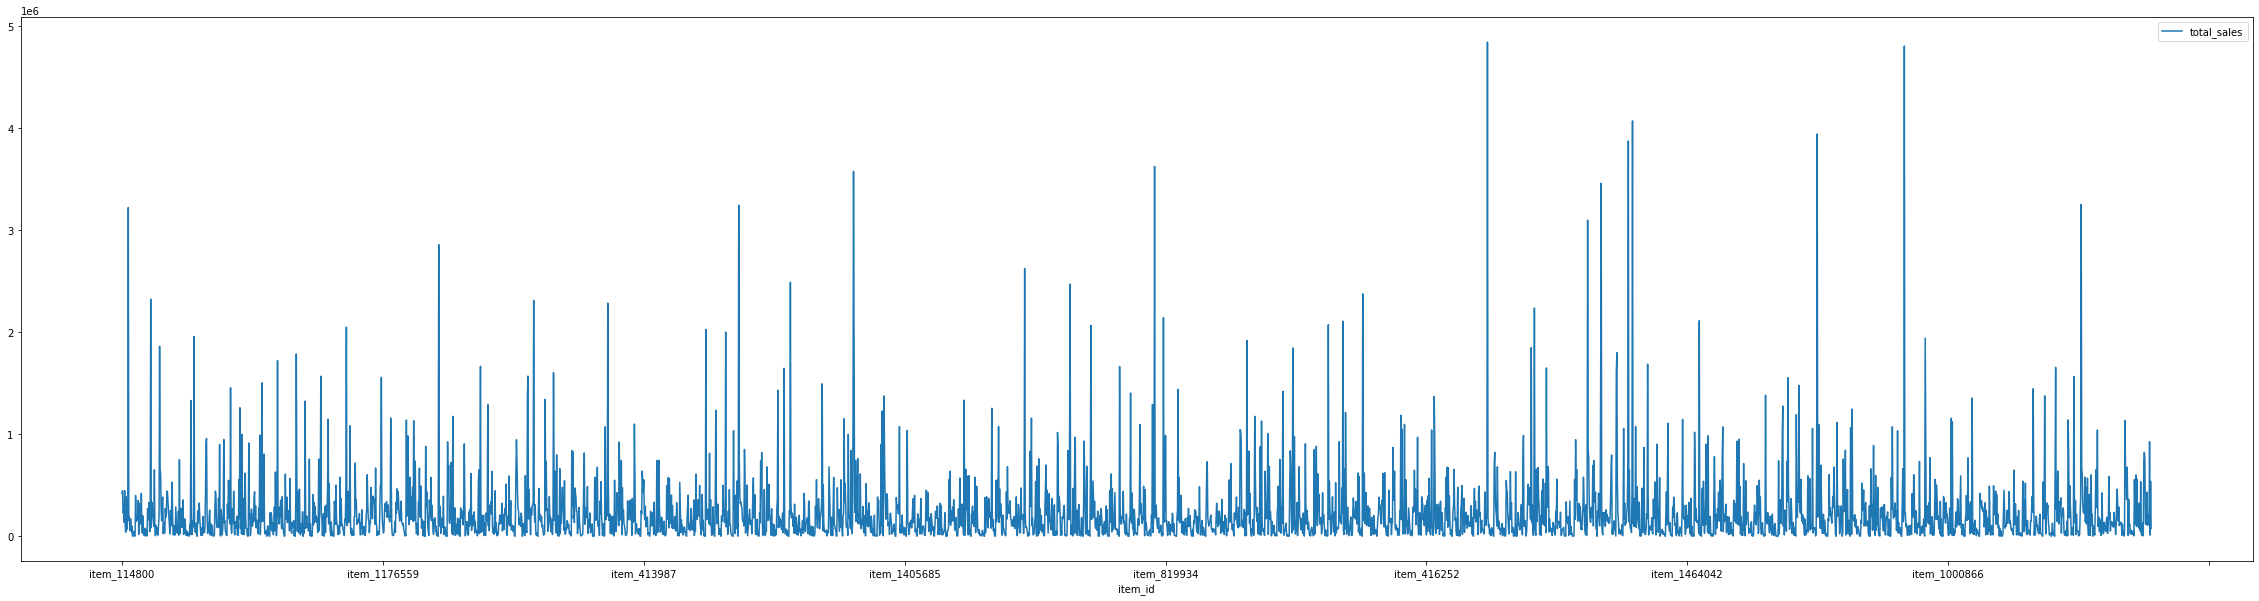

In [ ]:
#Finding Item having highest sales (Plot 1) and Items above mean sales (Plot 2)

sales_table_highest_Item=pd.read_pickle('/content/drive/MyDrive/Final_Hack/Highest_Item_sales')
sales_table_highest_Item.sort_values('total_sales',ascending=False)
sales_table_highest_Item.set_index('item_id',inplace=True)
sales_table_highest_Item.plot(figsize=(40
                                       ,10))

In [ ]:
sales_Item[sales_Item['total_sales']==sales_Item.total_sales.max()]


,item_id,total_sales
2617,item_1503844,4.845388e+06


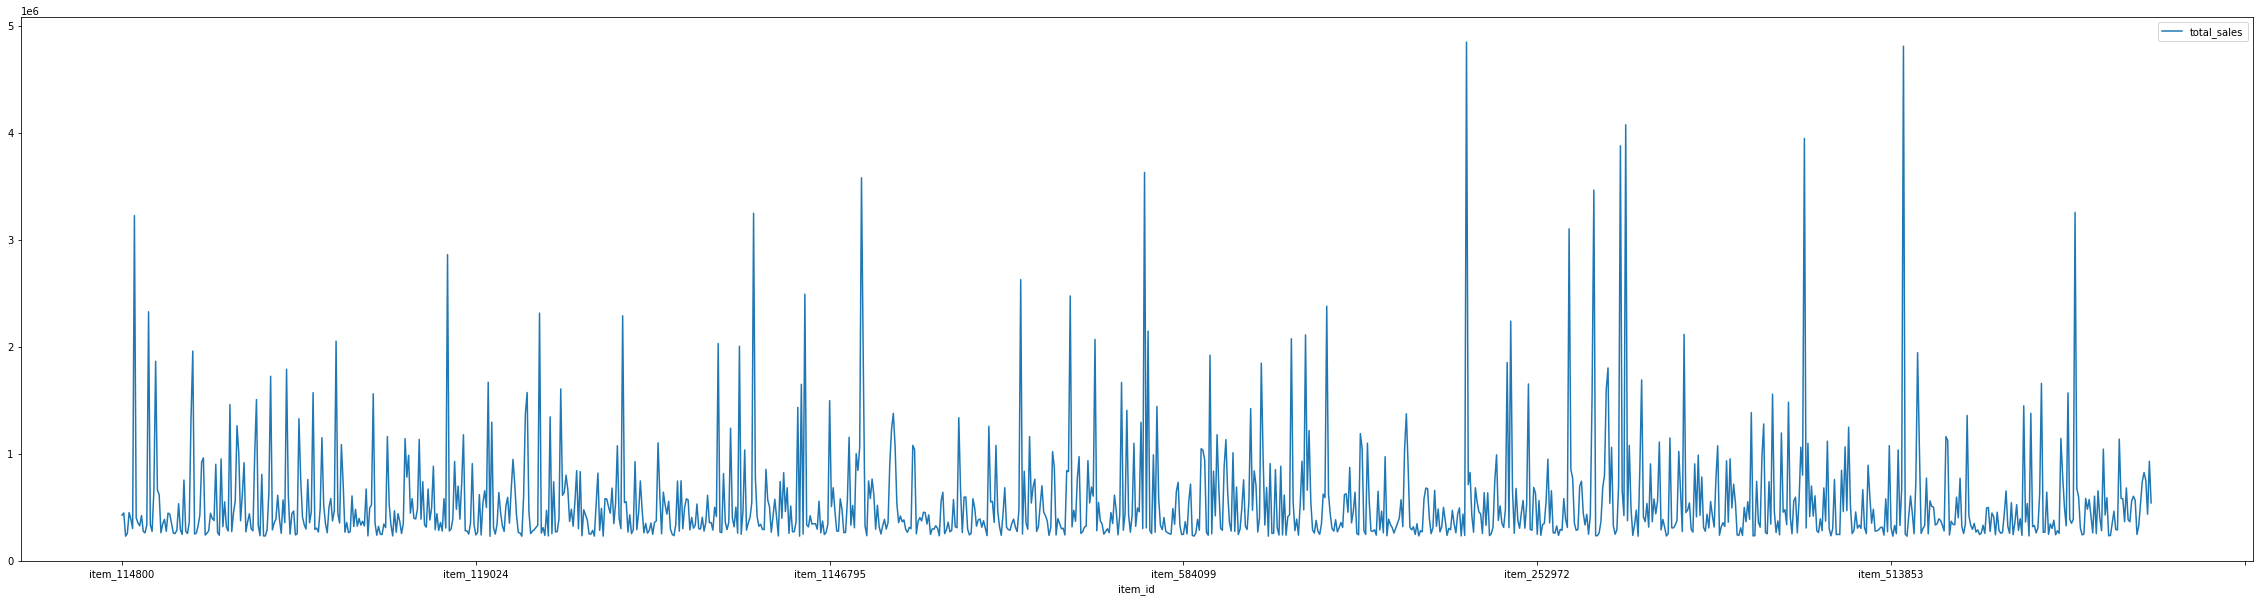

In [ ]:
sales_table_highest_Item.loc[sales_table_highest_Item['total_sales']>sales_table_highest_Item.total_sales.mean()].plot(figsize=(40,10))

# Reading Pickle files 

1.   Pickle files created after merging tables using pyspark
2.   Itemwise pickle file for easy access for modelling





In [ ]:
##*****************Reading from Pickle file for faster access************
pdf_item_1503844=pd.read_pickle('/content/drive/MyDrive/Final_Hack/pdf_item_1503844')
pdf_item_1047679=pd.read_pickle('/content/drive/MyDrive/Final_Hack/pdf_item_1047679')
pdf_item_1047679.dtypes

date                 object
locationId           object
item_id              object
_c0                  object
unit_sales           object
onpromotion          object
city                 object
state                object
type                 object
cluster               int32
category_of_item     object
class                object
perishable            int32
transactions        float64
dtype: object

In [ ]:
pdf_item_1503844['date']=pd.to_datetime(pdf_item_1503844['date'])
pdf_item_1047679['date']=pd.to_datetime(pdf_item_1047679['date'])
pdf_item_1503844['state']=pdf_item_1503844['state'].astype('category')
pdf_item_1047679['state']=pdf_item_1047679['state'].astype('category')
pdf_item_1503844['unit_sales']=pdf_item_1503844['unit_sales'].astype('float')
pdf_item_1047679['unit_sales']=pdf_item_1047679['unit_sales'].astype('float')
pdf_item_1503844['type']=pdf_item_1503844['type'].astype('category')
pdf_item_1047679['type']=pdf_item_1047679['type'].astype('category')
pdf_item_1503844['item_id']=pdf_item_1503844['item_id'].astype('category')
pdf_item_1047679['item_id']=pdf_item_1047679['item_id'].astype('category')
pdf_item_1503844['locationId']=pdf_item_1503844['locationId'].astype('category')
pdf_item_1047679['locationId']=pdf_item_1047679['locationId'].astype('category')

In [ ]:
pdf_item_1503844['year']=pdf_item_1503844['date'].dt.year
pdf_item_1503844['month']=pdf_item_1503844['date'].dt.month

pdf_item_1047679['year']=pdf_item_1047679['date'].dt.year
pdf_item_1047679['month']=pdf_item_1047679['date'].dt.month

In [ ]:

pdf_item_1503844=pdf_item_1503844.set_index(['date'])
pdf_item_1503844.index=pd.to_datetime(pdf_item_1503844.index,unit='s')

pdf_item_1047679=pdf_item_1047679.set_index(['date'])
pdf_item_1047679.index=pd.to_datetime(pdf_item_1047679.index,unit='s')


**Sales of the item_1503844 satewise**

*   Maharashtra has highest recorded sales for this item
*   Maharashtra has sales highest across the time period



In [ ]:
pdf_item_1503844.loc[pdf_item_1503844['state'] == s, 'unit_sales'].resample('D').sum()

date
2016-01-02               10.892
2016-01-03                5.985
2016-01-04           6.9234.185
2016-01-05             9.5383.6
2016-01-06    9.35416.92314.878
                    ...        
2018-12-27                    0
2018-12-28                3.351
2018-12-29                3.027
2018-12-30          17.1893.378
2018-12-31                6.595
Freq: D, Name: unit_sales, Length: 1095, dtype: object

In [75]:
x=df2.loc[df2['year']==2018,['unit_sales']]
x.reset_index()
x['unit_sales'].describe

<bound method NDFrame.describe of date
2018-01-01    12.0
2018-01-01     9.0
2018-01-01     3.0
2018-01-01     3.0
2018-01-01     2.0
              ... 
2018-12-31     6.0
2018-12-31     4.0
2018-12-31    10.0
2018-12-31     3.0
2018-12-31     1.0
Name: unit_sales, Length: 32233160, dtype: float64>

In [87]:
transaction_train.columns

Index(['date', 'location_identifier', 'transactions'], dtype='object')

In [42]:
y_sales=df2.groupby('year')['unit_sales'].sum().to_frame()

In [44]:
y_sales['percentage']=(y_sales['unit_sales']/y_sales.unit_sales.min())*100
y_sales

,unit_sales,percentage
year,,
2015,7.681116e+07,100.000000
2016,1.053046e+08,137.095452
2017,1.282167e+08,166.924503
2018,1.563394e+08,203.537360


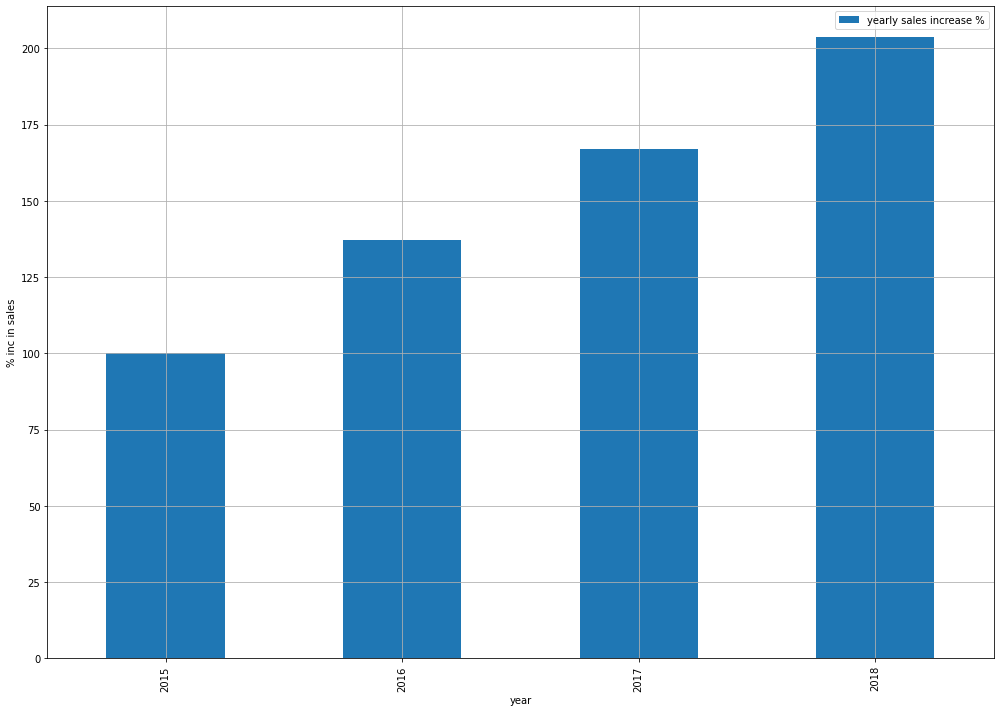

In [56]:
fig, axes = plt.subplots( figsize=(14, 10))


 
t = y_sales.percentage
ax = t.plot(label='yearly sales increase %',linewidth=4,kind='bar') 
ax.grid()
ax.set_xlabel('year')
ax.set_ylabel('% inc in sales')
ax.legend()
    
fig.tight_layout();

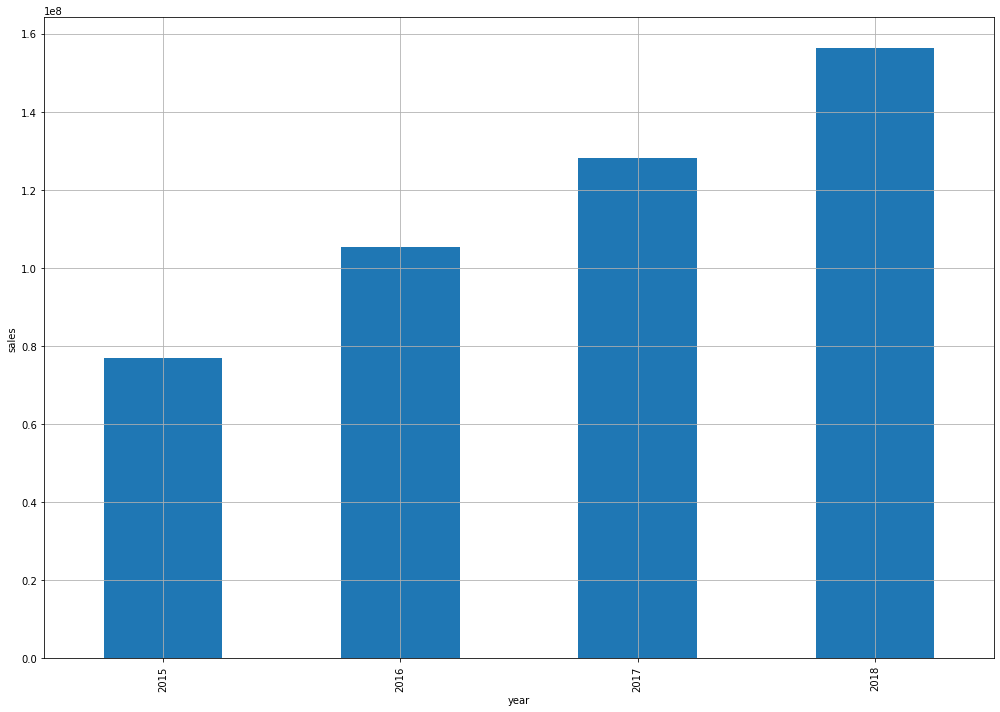

In [40]:

fig, axes = plt.subplots( figsize=(14, 10))


 
t = df2.groupby('year')['unit_sales'].sum()
ax = t.plot(label=s,linewidth=4,kind='bar') 
ax.grid()
ax.set_xlabel('year')
ax.set_ylabel('sales')

    
fig.tight_layout();

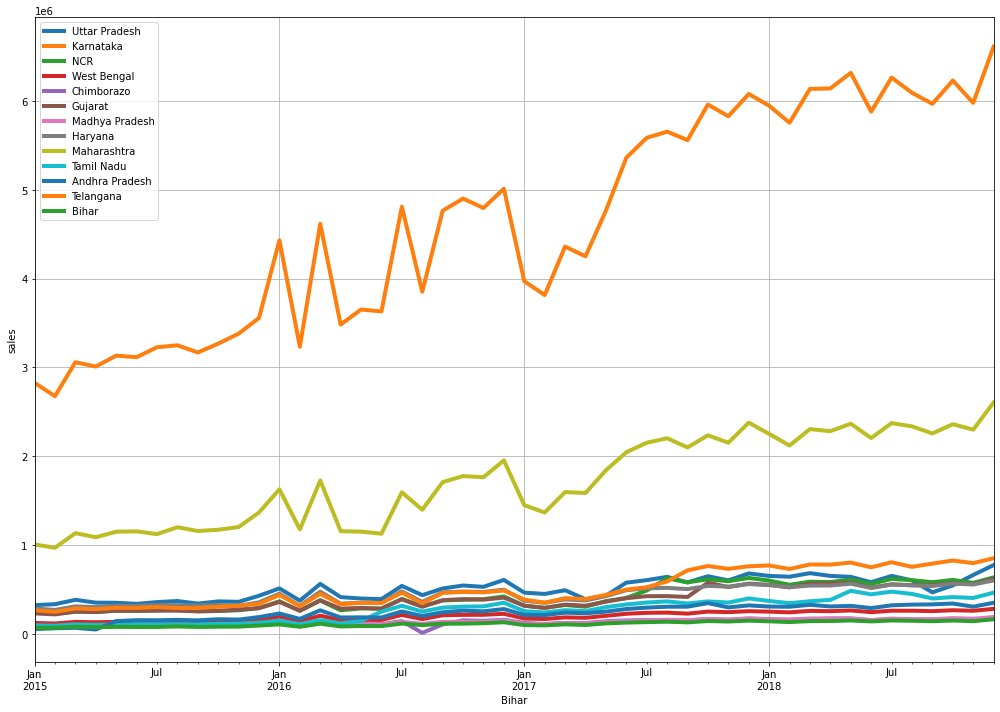

In [33]:
num_states = len(df2['state'].unique())
fig, axes = plt.subplots( figsize=(14, 10))

flag=0
for s in df2['state'].unique():
 
    t = df2.loc[df2['state']==s , 'unit_sales'].resample('M').sum()
    ax = t.plot(label=s,linewidth=4) 
    ax.grid()
    ax.set_xlabel(s)
    ax.set_ylabel('sales')
    ax.legend()
    flag=flag+1
fig.tight_layout();

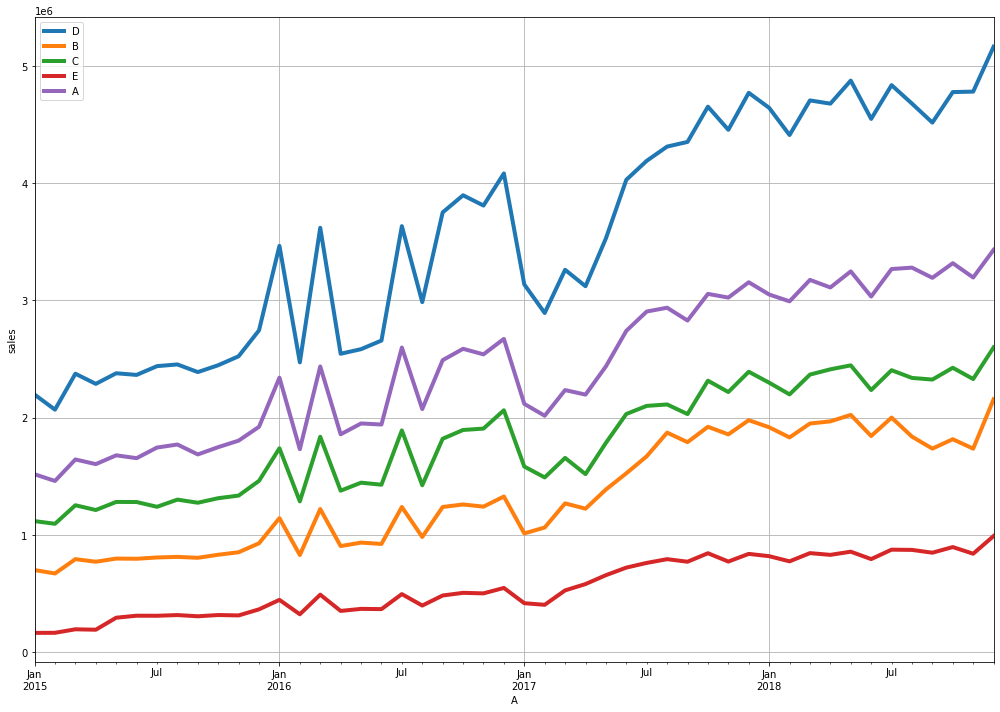

In [79]:
num_states = len(df2['type'].unique())
fig, axes = plt.subplots( figsize=(14, 10))

flag=0
for s in df2['type'].unique():
 
    t = df2.loc[df2['type']==s , 'unit_sales'].resample('M').sum()
    ax = t.plot(label=s,linewidth=4) 
    ax.grid()
    ax.set_xlabel(s)
    ax.set_ylabel('sales')
    ax.legend()
    flag=flag+1
fig.tight_layout();

In [ ]:
pdf_item_1503844['cluster']=pdf_item_1503844['cluster'].astype('category')
pdf_item_1503844.head()

,locationId,item_id,_c0,unit_sales,onpromotion,city,state,type,cluster,category_of_item,class,perishable,transactions,year,month
date,,,,,,,,,,,,,,,
2016-01-02,location_31,item_1503844,16361843,10.892,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1471.0,2016,1
2016-01-03,location_26,item_1503844,16422851,5.985,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,725.0,2016,1
2016-01-04,location_26,item_1503844,16489599,6.923,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,810.0,2016,1
2016-01-04,location_31,item_1503844,16494960,4.185,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1573.0,2016,1
2016-01-05,location_5,item_1503844,16533615,14.000,None,Delhi,NCR,D,4,other_farm_produce,class_2022,1,1669.0,2016,1


**Sales of the item cluster wise**

cluster
1       13
2        4
3      108
4       75
6      363
7        4
8        1
9        3
10    1193
11       1
13       4
15      18
16      41
17       3
Name: state, dtype: int64

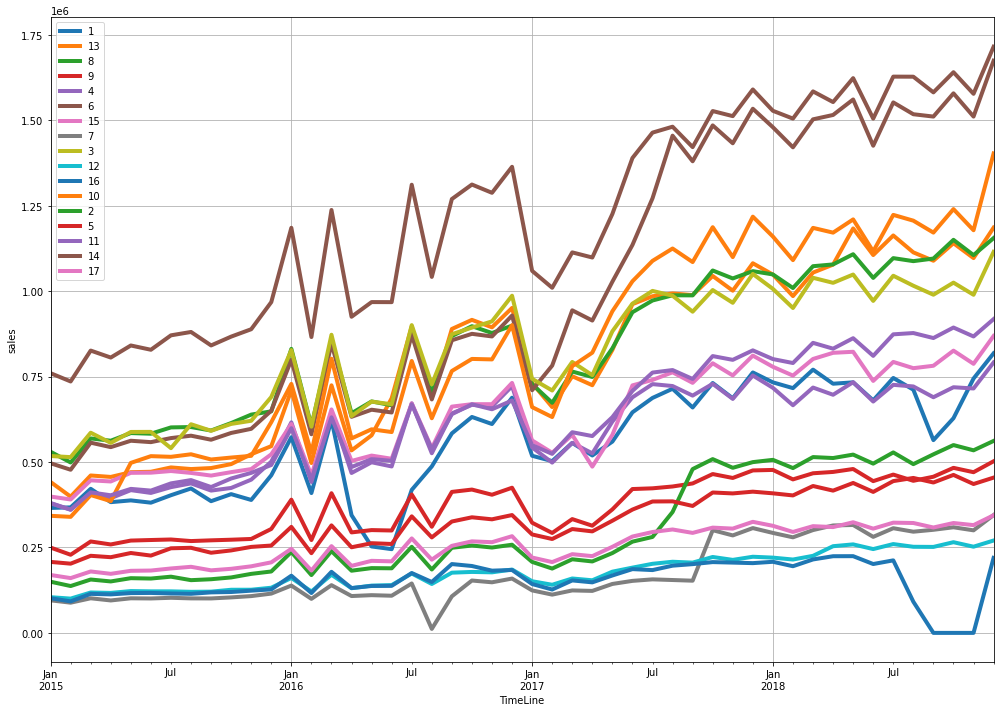

In [22]:
num_states = len(df2['cluster'].unique())
fig, axes = plt.subplots( figsize=(14, 10))

flag=0
for s in df2['cluster'].unique():
 
    t = df2.loc[df2['cluster'] == s, 'unit_sales'].resample('M').sum()
    ax = t.plot(label=s,linewidth=4,linestyle='-') 
    ax.grid()
    ax.set_xlabel('TimeLine')
    ax.set_ylabel('sales')
    
    ax.legend()
    flag=flag+1
fig.tight_layout();

**Sales of the item citywise**

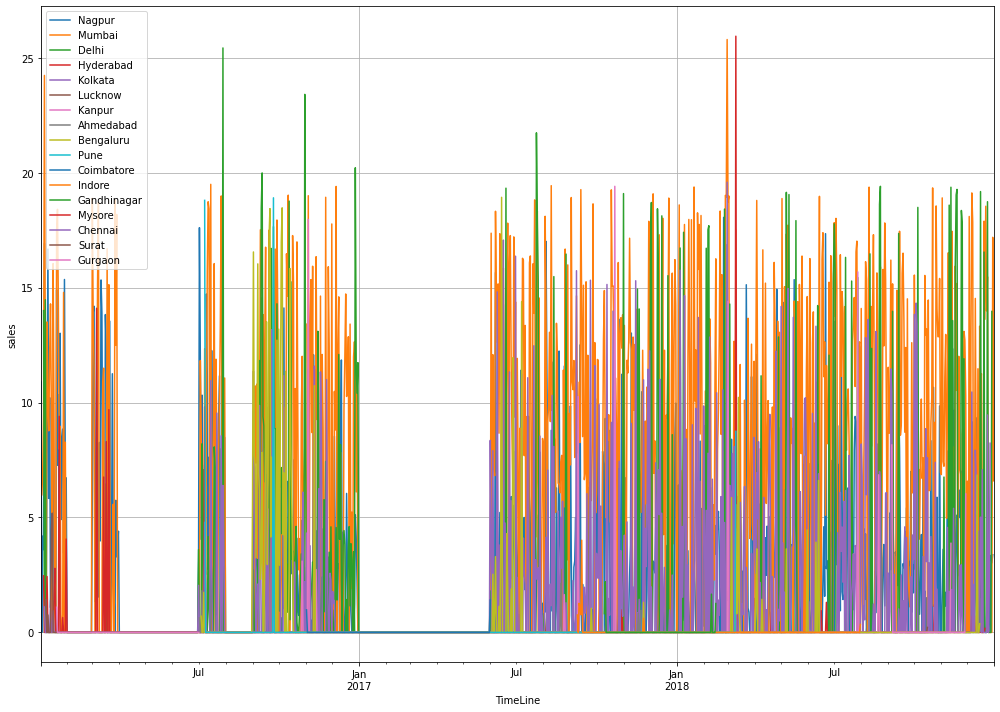

In [ ]:
num_states = len(pdf_item_1503844['city'].unique())
fig, axes = plt.subplots( figsize=(14, 10))

flag=0
for s in pdf_item_1503844['city'].unique():
 
    t = pdf_item_1503844.loc[pdf_item_1503844['city'] == s, 'unit_sales'].resample('D').sum()
    ax = t.plot(label=s) 
    ax.grid()
    ax.set_xlabel('TimeLine')
    ax.set_ylabel('sales')
    ax.legend()
    flag=flag+1
fig.tight_layout();

**Which Business unit had highest sale for form 2015 to 2019 for this Item_1503844**

*   Business unit type C has highest sales recorded
*   Business unit type E has lowest sales



Text(0, 0.5, 'sales Xe6')

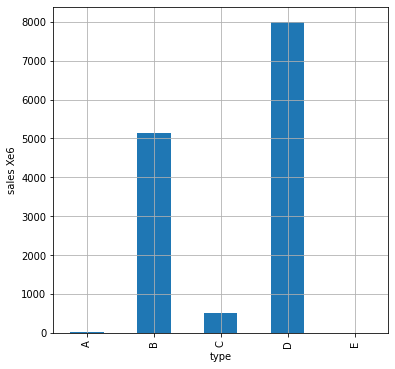

In [ ]:
fig=plt.subplots(figsize=(6,6))
t=pdf_item_1503844.groupby(['type'])['unit_sales'].sum()
ax=t.plot(kind='bar')
ax.grid()
ax.set_ylabel('sales Xe6')


In [ ]:
pdf_item_1503844.head()

,locationId,item_id,_c0,unit_sales,onpromotion,city,state,type,cluster,category_of_item,class,perishable,transactions,year,month
date,,,,,,,,,,,,,,,
2016-01-02,location_31,item_1503844,16361843,10.892,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1471.0,2016,1
2016-01-03,location_26,item_1503844,16422851,5.985,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,725.0,2016,1
2016-01-04,location_26,item_1503844,16489599,6.923,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,810.0,2016,1
2016-01-04,location_31,item_1503844,16494960,4.185,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1573.0,2016,1
2016-01-05,location_5,item_1503844,16533615,14.000,None,Delhi,NCR,D,4,other_farm_produce,class_2022,1,1669.0,2016,1


In [ ]:
pdf_item_1503844['Address']=pdf_item_1503844['city'].astype('string')+','+pdf_item_1503844['state'].astype('string')

In [ ]:
pdf_item_1503844.head()

,locationId,item_id,_c0,unit_sales,onpromotion,city,state,type,cluster,category_of_item,class,perishable,transactions,year,month,Address,Lat_x,Long_x,Points,Lat_y,Long_y
0,location_31,item_1503844,16361843,10.892,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1471.0,2016,1,"Nagpur,Maharashtra",NaN,NaN,"(nan, nan)",NaN,NaN
1,location_26,item_1503844,16422851,5.985,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,725.0,2016,1,"Mumbai,Maharashtra",NaN,NaN,"(nan, nan)",NaN,NaN
2,location_26,item_1503844,16489599,6.923,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,810.0,2016,1,"Mumbai,Maharashtra",NaN,NaN,"(nan, nan)",NaN,NaN
3,location_31,item_1503844,16494960,4.185,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1573.0,2016,1,"Nagpur,Maharashtra",NaN,NaN,"(nan, nan)",NaN,NaN
4,location_5,item_1503844,16533615,14.000,None,Delhi,NCR,D,4,other_farm_produce,class_2022,1,1669.0,2016,1,"Delhi,NCR",NaN,NaN,"(nan, nan)",NaN,NaN


# Spatial Visualizations

**Geocoding the Data based on location**

In [ ]:
geolocations=pd.read_csv('/content/drive/MyDrive/Final_Hack/geolocations.csv')

In [ ]:
pdf_item_1503844=pd.merge(pdf_item_1503844,geolocations,how='left',on='Address')


In [ ]:
pdf_item_1503844.head()

,locationId,item_id,_c0,unit_sales,onpromotion,city,state,type,cluster,category_of_item,class,perishable,transactions,year,month,Address,Lat_x,Long_x,Points,Lat_y,Long_y,Lat,Long
0,location_31,item_1503844,16361843,10.892,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1471.0,2016,1,"Nagpur,Maharashtra",NaN,NaN,"(nan, nan)",NaN,NaN,21.1458,79.0882
1,location_26,item_1503844,16422851,5.985,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,725.0,2016,1,"Mumbai,Maharashtra",NaN,NaN,"(nan, nan)",NaN,NaN,19.0760,72.8777
2,location_26,item_1503844,16489599,6.923,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,810.0,2016,1,"Mumbai,Maharashtra",NaN,NaN,"(nan, nan)",NaN,NaN,19.0760,72.8777
3,location_31,item_1503844,16494960,4.185,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1573.0,2016,1,"Nagpur,Maharashtra",NaN,NaN,"(nan, nan)",NaN,NaN,21.1458,79.0882
4,location_5,item_1503844,16533615,14.000,None,Delhi,NCR,D,4,other_farm_produce,class_2022,1,1669.0,2016,1,"Delhi,NCR",NaN,NaN,"(nan, nan)",NaN,NaN,28.7041,77.1025


In [ ]:
pdf_item_1503844['Points']=list(zip(pdf_item_1503844['Long'],pdf_item_1503844['Lat']))

In [ ]:
pdf_item_1503844.drop(columns=['Lat_x','Lat_y','Long_x','Long_y'],inplace=True)

In [ ]:


pdf_item_1503844['Points']=pdf_item_1503844['Points'].apply(Point)

In [ ]:
gdf_item_1503844=gpd.GeoDataFrame(pdf_item_1503844,geometry='Points')

In [ ]:
gdf_item_1503844.head()

,locationId,item_id,_c0,unit_sales,onpromotion,city,state,type,cluster,category_of_item,class,perishable,transactions,year,month,Address,Points,Lat,Long
0,location_31,item_1503844,16361843,10.892,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1471.0,2016,1,"Nagpur,Maharashtra",POINT (79.08820 21.14580),21.1458,79.0882
1,location_26,item_1503844,16422851,5.985,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,725.0,2016,1,"Mumbai,Maharashtra",POINT (72.87770 19.07600),19.0760,72.8777
2,location_26,item_1503844,16489599,6.923,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,810.0,2016,1,"Mumbai,Maharashtra",POINT (72.87770 19.07600),19.0760,72.8777
3,location_31,item_1503844,16494960,4.185,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1573.0,2016,1,"Nagpur,Maharashtra",POINT (79.08820 21.14580),21.1458,79.0882
4,location_5,item_1503844,16533615,14.000,None,Delhi,NCR,D,4,other_farm_produce,class_2022,1,1669.0,2016,1,"Delhi,NCR",POINT (77.10250 28.70410),28.7041,77.1025


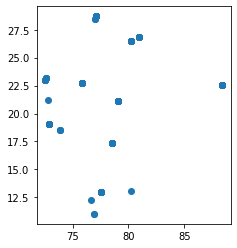

In [ ]:
gdf_item_1503844.plot()

In [ ]:
gdf_item_1503844.head()

,locationId,item_id,_c0,unit_sales,onpromotion,city,state,type,cluster,category_of_item,class,perishable,transactions,year,month,Address,Points,Lat,Long
0,location_31,item_1503844,16361843,10.892,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1471.0,2016,1,"Nagpur,Maharashtra",POINT (79.08820 21.14580),21.1458,79.0882
1,location_26,item_1503844,16422851,5.985,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,725.0,2016,1,"Mumbai,Maharashtra",POINT (72.87770 19.07600),19.0760,72.8777
2,location_26,item_1503844,16489599,6.923,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,810.0,2016,1,"Mumbai,Maharashtra",POINT (72.87770 19.07600),19.0760,72.8777
3,location_31,item_1503844,16494960,4.185,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1573.0,2016,1,"Nagpur,Maharashtra",POINT (79.08820 21.14580),21.1458,79.0882
4,location_5,item_1503844,16533615,14.000,None,Delhi,NCR,D,4,other_farm_produce,class_2022,1,1669.0,2016,1,"Delhi,NCR",POINT (77.10250 28.70410),28.7041,77.1025


In [96]:
import geopandas as gpd
states=gpd.read_file('/content/drive/MyDrive/Final_Hack/india_administrative_state_boundary/india_administrative_state_boundary.shp')
# ax=states.plot(edgecolor='k',facecolor='none',figsize=(20,10))
# gdf_item_1503844.plot(ax=ax,color='red')

Text(0.5, 0, 'states')

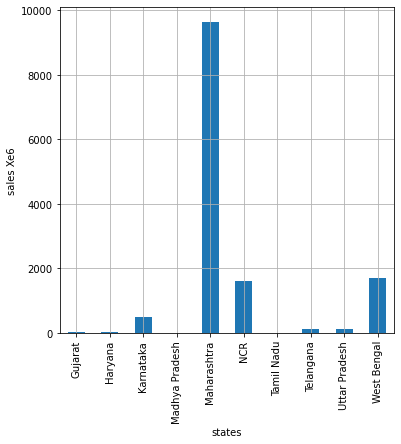

In [ ]:
cum_Sales_statewise=gdf_item_1503844.groupby('state')['unit_sales'].sum().to_frame()


fig=plt.subplots(figsize=(6,6))
t=cum_Sales_statewise.unit_sales
ax=t.plot(kind='bar')
ax.grid()
ax.set_ylabel('sales Xe6')
ax.set_xlabel('states')



**We can observe that Maharastra has highest sales figure among the states followed by NCR**

In [104]:
state_sales=df2.groupby('state')['unit_sales'].sum()
state_sales.sort_values(ascending=False)


state
Karnataka         2.233661e+08
Maharashtra       8.277788e+07
Telangana         2.446754e+07
Uttar Pradesh     2.427495e+07
Haryana           2.100353e+07
NCR               1.989309e+07
Gujarat           1.888151e+07
Tamil Nadu        1.290647e+07
Andhra Pradesh    1.138264e+07
West Bengal       9.599196e+06
Chimborazo        6.386904e+06
Madhya Pradesh    6.267758e+06
Bihar             5.464287e+06
Name: unit_sales, dtype: float64

In [101]:
states['st_nm']=states['st_nm'].replace(['NCT of Delhi'],'NCR')

In [114]:
#cum_Sales_statewise.reset_index()

gpd_sates=pd.merge(states,state_sales,left_on='st_nm',right_on='state',how='left')
gpd_sates['unit_sales']=gpd_sates['unit_sales'].fillna(0)
gpd_sates.dtypes

gid              int64
st_nm           object
tid             object
territory_      object
geometry      geometry
unit_sales     float64
dtype: object

In [130]:
gpd_sates['sales_category']=pd.cut(gpd_sates['unit_sales'],[-1,1000,2300000,4500000,250000000],labels=['Zero sales','Low sales','Medium sales','High sales'])
gpd_sates

,gid,st_nm,tid,territory_,geometry,unit_sales,sales_category
0,1,Andaman & Nicobar Island,None,None,"MULTIPOLYGON (((93.71976 7.20707, 93.71909 7.2...",0.000000e+00,Zero sales
1,2,Arunanchal Pradesh,None,None,"POLYGON ((96.16261 29.38078, 96.16860 29.37432...",0.000000e+00,Zero sales
2,3,Assam,None,None,"MULTIPOLYGON (((89.74323 26.30362, 89.74290 26...",0.000000e+00,Zero sales
3,4,Bihar,None,None,"MULTIPOLYGON (((84.50720 24.26323, 84.50355 24...",5.464287e+06,High sales
4,5,Chandigarh,None,None,"POLYGON ((76.84147 30.75996, 76.83599 30.73623...",0.000000e+00,Zero sales
5,6,Chhattisgarh,None,None,"POLYGON ((83.33532 24.09885, 83.35346 24.09627...",0.000000e+00,Zero sales
6,7,Dadara & Nagar Havelli,None,None,"POLYGON ((73.20657 20.12216, 73.20797 20.10650...",0.000000e+00,Zero sales
7,8,Daman & Diu,None,None,"MULTIPOLYGON (((72.89335 20.44539, 72.89281 20...",0.000000e+00,Zero sales
8,9,Goa,None,None,"MULTIPOLYGON (((74.11918 14.75344, 74.11350 14...",0.000000e+00,Zero sales
9,10,Gujarat,None,None,"MULTIPOLYGON (((71.70375 20.99958, 71.70375 20...",1.888151e+07,High sales


In [119]:
!pip install mapclassify

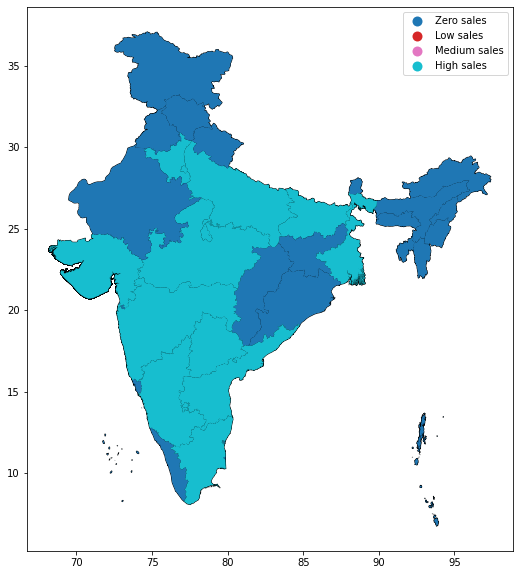

In [131]:
import mapclassify as mc
import matplotlib.pyplot as plt

ax=states.plot(edgecolor='k',facecolor='none',figsize=(20,10))
gpd_sates.plot(column='sales_category',ax=ax,legend=True,k=4)

In [ ]:
states.index

RangeIndex(start=0, stop=36, step=1)

In [ ]:
sales_state=pd.merge(states,cum_Sales_statewise,left_on='st_nm',right_on='state',how='inner')
sales_state

,gid,st_nm,tid,territory_,geometry,unit_sales
0,10,Gujarat,None,None,"MULTIPOLYGON (((71.70375 20.99958, 71.70375 20...",14.8670
1,11,Haryana,None,None,"POLYGON ((76.85065 30.87512, 76.86594 30.86691...",14.1740
2,15,Karnataka,None,None,"MULTIPOLYGON (((74.69694 13.32782, 74.69562 13...",479.5410
3,18,Madhya Pradesh,None,None,"MULTIPOLYGON (((74.17932 22.39059, 74.17776 22...",8.8460
4,19,Maharashtra,None,None,"MULTIPOLYGON (((73.46270 16.03710, 73.46178 16...",9628.8933
5,29,Tamil Nadu,None,None,"MULTIPOLYGON (((78.19188 8.72730, 78.18996 8.7...",3.1530
6,30,Telangana,None,None,"POLYGON ((81.05614 17.79097, 81.05834 17.75464...",108.6310
7,32,Uttar Pradesh,None,None,"MULTIPOLYGON (((80.44802 24.99631, 80.44080 24...",111.3424
8,34,West Bengal,None,None,"MULTIPOLYGON (((88.01861 21.57278, 88.01889 21...",1703.1970


In [ ]:
!pip install mapclassify

***`We can observe the states which comes under high sales bands and low sales bands `***

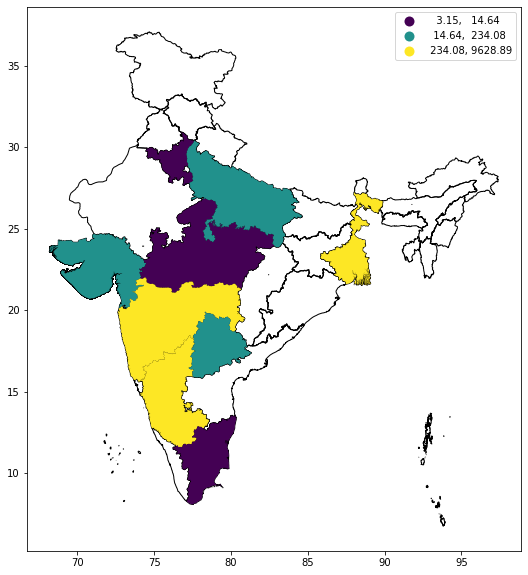

In [ ]:
import mapclassify as mc
import matplotlib.pyplot as plt

ax=states.plot(edgecolor='k',facecolor='none',figsize=(20,10))
sales_state.plot(column='unit_sales',scheme='Quantiles',ax=ax,legend=True,k=3)

## **We can observe 3 levels of sales for this item**


1.   High sales states
2.   Medium sales states
3.   Low sales states



# Model Building (Time series)


1.   Tried time series model to develop predictions
2.   Tried Arima, Auto Arima & SARIMAX.
3.   Forecasted for weekly sales.
4.   work in progress for daily sales



In [ ]:
!pip install statsmodels

In [ ]:
pdf_item_1503844.head()

,locationId,item_id,_c0,unit_sales,onpromotion,city,state,type,cluster,category_of_item,class,perishable,transactions,year,month
date,,,,,,,,,,,,,,,
2016-01-02,location_31,item_1503844,16361843,10.892,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1471.0,2016,1
2016-01-03,location_26,item_1503844,16422851,5.985,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,725.0,2016,1
2016-01-04,location_26,item_1503844,16489599,6.923,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,810.0,2016,1
2016-01-04,location_31,item_1503844,16494960,4.185,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1573.0,2016,1
2016-01-05,location_5,item_1503844,16533615,14.000,None,Delhi,NCR,D,4,other_farm_produce,class_2022,1,1669.0,2016,1


In [ ]:
pdf_item_1047679.reset_index(inplace=True)
ts_item_1047679=pdf_item_1047679.groupby('date')['unit_sales'].sum().to_frame()

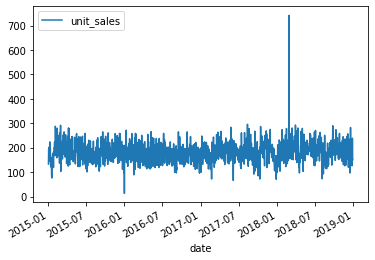

In [ ]:
ts_item_1047679.plot()

In [ ]:
ts_item_1047679.to_pickle('/content/drive/MyDrive/Final_Hack/time_series_data')

**Weekly predictions**

In [ ]:
t = ts_item_1047679['unit_sales'].resample('w').sum()
t=t.to_frame()

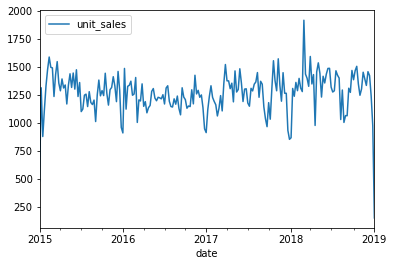

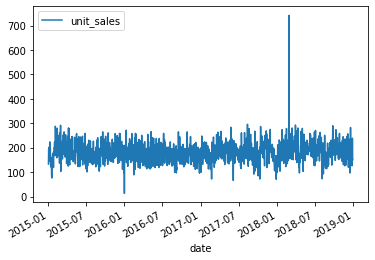

In [ ]:
t.plot()
ts_item_1047679.plot()

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
adfuller(t['unit_sales'])

(-8.91765614575976,
 1.0619191675120198e-14,
 0,
 209,
 {'1%': -3.4620315036789666,
  '10%': -2.5741950726860647,
  '5%': -2.8754705024827127},
 2517.6173209332796)

In [ ]:
adfuller(ts_item_1047679['unit_sales'])

(-5.950419358759848,
 2.1538136988144377e-07,
 20,
 1432,
 {'1%': -3.4349247631306237,
  '10%': -2.5678456715029183,
  '5%': -2.8635604442944658},
 14570.010874154603)

In [ ]:

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
adfuller_test(t['unit_sales'])

ADF Test Statistic : -8.91765614575976
p-value : 1.0619191675120198e-14
#Lags Used : 0
Number of Observations Used : 209
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [ ]:
adfuller_test(ts_item_1047679['unit_sales'])

ADF Test Statistic : -5.950419358759848
p-value : 2.1538136988144377e-07
#Lags Used : 20
Number of Observations Used : 1432
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


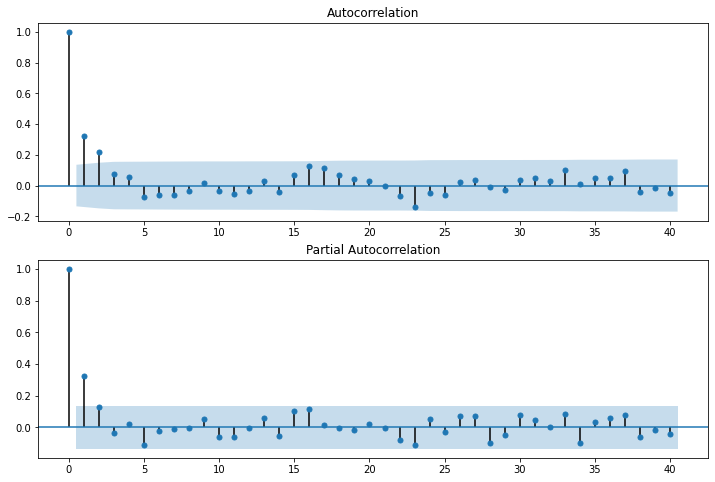

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(t['unit_sales'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(t['unit_sales'],lags=40,ax=ax2)

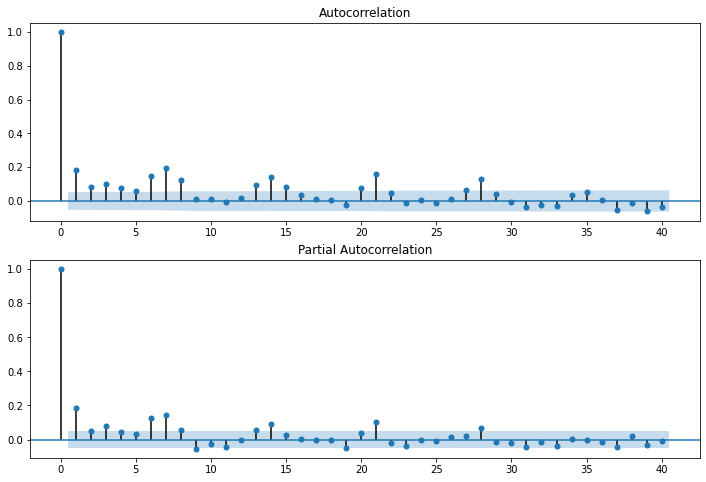

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_item_1047679['unit_sales'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_item_1047679['unit_sales'],lags=40,ax=ax2)

In [ ]:
model=sm.tsa.statespace.SARIMAX(t['unit_sales'],order=(3, 3, 1),seasonal_order=(3,3,1,7))
results=model.fit()

In [ ]:
daily_model=sm.tsa.statespace.SARIMAX(ts_item_1047679['unit_sales'],order=(5, 2, 1),seasonal_order=(5,2,1,12))
daily_results=daily_model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


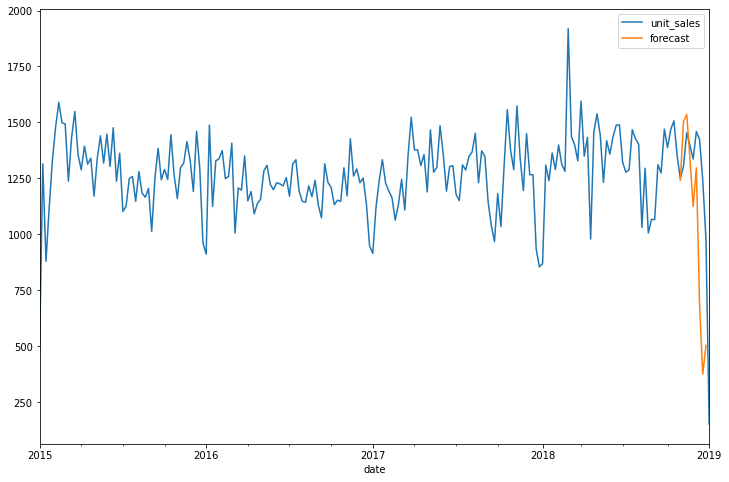

In [ ]:

t['forecast']=results.predict(start=200,end=208,dynamic=True)
t[['unit_sales','forecast']].plot(figsize=(12,8))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


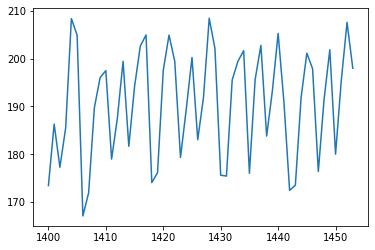

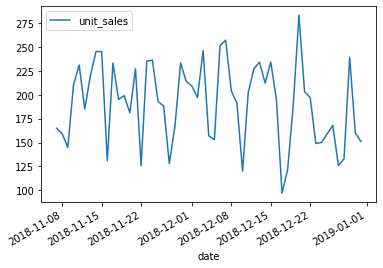

In [ ]:
forecast=daily_results.predict(start=1400,end=1453,dynamic=True)
t=forecast.plot()
ts_item_1047679[1399:].plot()

In [ ]:
print(forecast.shape)

(54,)


In [ ]:
ts_item_1047679[1399:].shape

(54, 2)

In [ ]:
from sklearn.metrics import *
mean_squared_error(ts_item_1047679[1399:],forecast)

2166.488007421502

Daily predictions With Arima & Auto Arima

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
ts_item_1047679
#ts_item_1047679.index = pd.DatetimeIndex(ts_item_1047679.index).to_period('D')

,unit_sales
date,
2015-01-02,133.0
2015-01-03,195.0
2015-01-04,155.0
2015-01-05,151.0
2015-01-06,203.0
...,...
2018-12-27,126.0
2018-12-28,133.0
2018-12-29,239.0


In [ ]:
ts_item_1047679.index

DatetimeIndex(['2015-01-02', '2015-01-03', '2015-01-04', '2015-01-05',
               '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09',
               '2015-01-10', '2015-01-11',
               ...
               '2018-12-21', '2018-12-22', '2018-12-23', '2018-12-24',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', name='date', length=1453, freq=None)

In [ ]:
model_without_S=ARIMA(ts_item_1047679['unit_sales'],order=(2,1,1))
model_without_S_fit=model_without_S.fit()

In [ ]:
model_without_S_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.unit_sales   No. Observations:                 1452
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -7437.916
Method:                       css-mle   S.D. of innovations             40.564
Date:                Fri, 23 Apr 2021   AIC                          14885.832
Time:                        06:18:31   BIC                          14912.235
Sample:                    01-03-2015   HQIC                         14895.684
                         - 12-31-2018                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0082      0.066      0.125      0.900      -0.120       0.137
ar.L1.D.unit_sales     0.1097      0.031      3.535      0.000       0.049       0.171
ar.L2.D.unit_sales    -0.0143      0.030     -0.469      0.639      -0.074       0.045
ma.L1.D.unit_sales    -0.9450      0.017    -55.524      0.000      -0.978      -0.912
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.8417           -7.4341j            8.3681           -0.1741
AR.2            3.8417           +7.4341j            8.3681            0.1741
MA.1            1.0582           +0.0000j            1.0582            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
!pip install pmdarima

In [ ]:
train,test=ts_item_1047679[:1090],ts_item_1047679[-363:]

In [ ]:
train.dtypes

unit_sales    float64
dtype: object

In [ ]:
len(ts_item_1047679.unit_sales)

1453

In [ ]:
test.index

DatetimeIndex(['2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12',
               '2018-01-13', '2018-01-14',
               ...
               '2018-12-21', '2018-12-22', '2018-12-23', '2018-12-24',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', name='date', length=360, freq=None)

In [ ]:
from pmdarima import auto_arima
A_arima=auto_arima(train,d=1,D=1,m=12,trend='c',seasonal=True,start_p=0,start_q=0,max_order=6,test='adf',stepwise=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.65 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=12250.164, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=11714.233, Time=1.44 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=5.53 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=12059.039, Time=0.18 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=11576.344, Time=6.66 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=9.15 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.44 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=11783.501, Time=3.29 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=11430.352, Time=9.70 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=11618.230, Time=2.62 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=12.63 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.35 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=11376.728, Time=9.23 sec
 ARIMA(3,1,0)(1,1,0)[12]             : A

In [ ]:
ts_item_1047679['forecast']=A_arima.predict(start=1095,end=1453,dynamic=True)
ts_item_1047679[['unit_sales','forecast']].plot(figsize=(12,8))

ValueError: ignored

In [ ]:
ts_item_1047679.iloc[1200:]

,unit_sales,forecast
date,,
2018-04-22,139.0,38.658653
2018-04-23,159.0,4.477716
2018-04-24,182.0,-0.053314
2018-04-25,218.0,-0.062355
2018-04-26,266.0,0.001358
...,...,...
2018-12-27,126.0,0.008224
2018-12-28,133.0,0.008224
2018-12-29,239.0,0.008224
